# Stain transformation demo

Here we demo the ```StainTransformer``` object, which allows one to manipulate the
staining characteristics of a Haematoxylin and Eosin (H&E) stained image.




## Stain Normalisation

First, let's deal with all of our imports.

In [1]:
from pathlib import Path
from itertools import product

from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np


from pystain import StainTransformer

Now, let us load the patches we will use to demonstrate the normalisation on, and stack them in a single image so we can compare them.

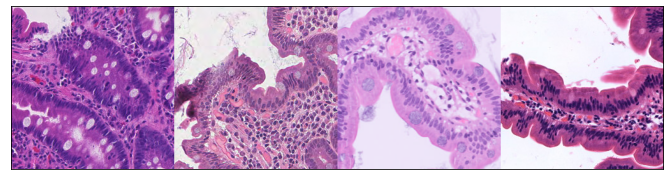

In [2]:
patches = sorted(list(Path("patches/").glob("*.png")))
patches = list(map(imread, patches))

top_img = np.concatenate(patches, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(top_img)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

We can clearly see that the source patches are different in their staining characteristics, which can cause significant problems for deep learning models.

Let us now normalise the patches using the ```StainTransformer``` object.

In [3]:
tfm = StainTransformer()
normed_patches = list(map(tfm, patches))


Now, we have a list of normalised patches, but they have been returned to us as tensors. We need to change them back into rgb images.

In [4]:
normed_patches = list(map(lambda x: (x.permute(1, 2, 0).numpy() * 255).astype(np.uint8), normed_patches))

Now, we compare the normalised images with their raw inputs.

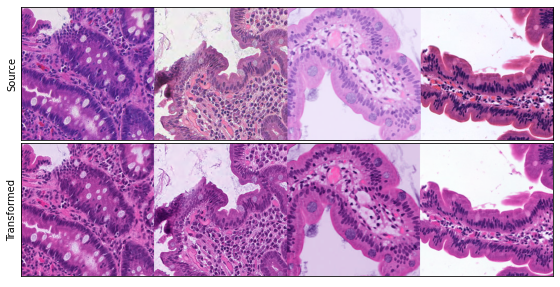

In [5]:
bottom_img = np.concatenate(normed_patches, axis=1)

fig, axes = plt.subplots(2, 1, figsize=(8.0, 4.0))
axes[0].imshow(top_img)
axes[1].imshow(bottom_img)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
for idx, ylabel in enumerate(["Source", "Transformed"]):
    axes[idx].set_ylabel(ylabel)

fig.tight_layout(h_pad=0, pad=0.75)
fig.savefig("norm-demo.pdf", dpi=500)

Note, by default ```StainTransformer``` has already been fit to a target image, so if you want to use a different target, simply call the fit method. For example:

```python
tfm = StainTransformer()
tfm.fit("new_target.png")
```

## Stain Jittering


Another useful feature of `StainTransformer` is the ability to "jitter" the estimated stain concentrations as a form of data augmentation. This augmentation can be useful for training a deep learning model similar to the way conventional colour jittering is applied.



In [6]:
tfm = StainTransformer(normalise=True, jitter=True, jitter_strength=0.2)

Note, we have two options: we can jitter normalised concentrations (by setting `normalise=True`) or we can jitter the concentrations in the input image without normalising it (`normalise=False`).

`jitter_strength = 0.2` is the default value, but feel free to play with it.

There is an open question as to whether it makes more sense to jitter, normalise, or do both, and the answer probably depends on one's data.

Let's get jittering.

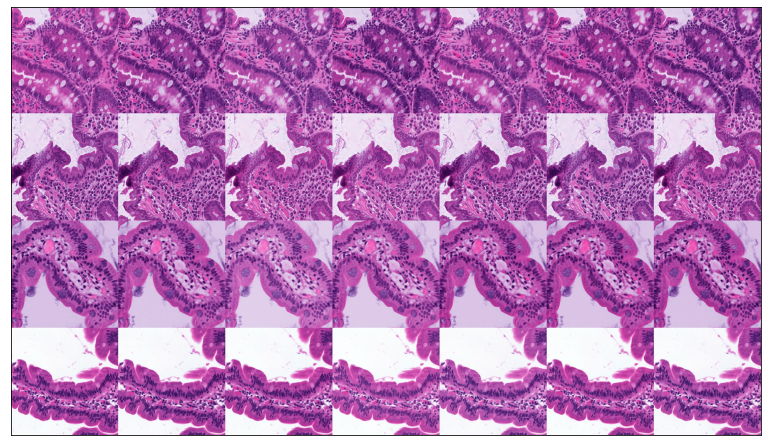

In [7]:
cols = 7
scale = 1.5

fig, axis = plt.subplots(1, 1, figsize=(cols * scale, len(patches) * scale))

imgs = []
for patch in patches:
    imgs.append(np.concatenate(list(map(lambda x: tfm(x).permute(1, 2, 0).numpy(), [patch for _ in range(cols)])), axis=1))

img = np.concatenate(imgs, axis=0)

axis.imshow(img)

_ = axis.set_xticks([])
_ = axis.set_yticks([])

fig.tight_layout(pad=0, h_pad=0, w_pad=0)
fig.savefig("jitter-demo.pdf", dpi=500)


We can see that in the above image, we have artificially modified the characteristics of the H and E stains.